# Image classifier using a pretrained CNN

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in an precision agriculture web application in order to recognize cultures and land positioning. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, we are training an image classifier to recognize different types of landscape structures. In practice you'd train this classifier, then export it for use in your application. We'll be using [UC Merced Land Use Dataset](http://weegee.vision.ucmerced.edu/datasets/landuse.html) of 21 categories, you can see a few examples below.

There are 100 images for each of the following classes:

| Categories       | Categories          | Categories          |
| ---------------- | ------------------- | ------------------- |
|- agricultural    | - forest            | - overpass          |
|- airplane        | - freeway           | - parkinglot        |
|- baseballdiamond | - golfcourse        | - river             |
|- beach           | - harbor            | - runway            |
|- buildings       | - intersection      | - sparseresidential |
|- chaparral       | - mediumresidential | - storagetanks      |
|- denseresidential| - mobilehomepark    | - tenniscourt       |

Each image measures 256x256 pixels.

| Category      | Image                                      |
| ------------- |:------------------------------------------:|
| airplane      | <img src='assets/airplane14.png' width=128px> |
| intersection  | <img src='assets/intersection36.png' width=128px> |
| river         | <img src='assets/river85.png' width=128px> |



The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about land structures/machines. But, what you do with your new skills depends on your imagination and effort in building a dataset.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
import os
import copy
import time

import itertools

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict
from matplotlib.ticker import FormatStrFormatter

from sklearn.metrics import confusion_matrix


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](http://weegee.vision.ucmerced.edu/datasets/landuse.html). The dataset has been split by the us into three parts, training, validation and test. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
#c:\Users\ubik\Projects\UCMercedLandUse-CNN-MLP\db\UCMerced_LandUse_split\Images\
data_dir = '../db/UCMerced_LandUse_split/Images'
learn_phases = ['train', 'valid', 'test']

In [3]:
# TODO: Define your transforms for the training and validation sets
data_transforms = data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in learn_phases}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=0)
              for x in learn_phases}

dataset_sizes = {x: len(image_datasets[x]) for x in learn_phases}
class_indices = image_datasets['train'].classes
class_name_to_idx = image_datasets['train'].class_to_idx

class_idx_to_name = dict([[idx, name] for name, idx in class_name_to_idx.items()])

class_names = list(class_idx_to_name.values())

# print out some data stats

print('Num training images: ', len(image_datasets['train']))
print('Num validation images: ', len(image_datasets['valid']))
print('Num test images: ', len(image_datasets['test']))
print('Num of classes: ', len(class_indices))
print('Classes: ', class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Num training images:  1680
Num validation images:  210
Num test images:  210
Num of classes:  21
Classes:  ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


## Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.

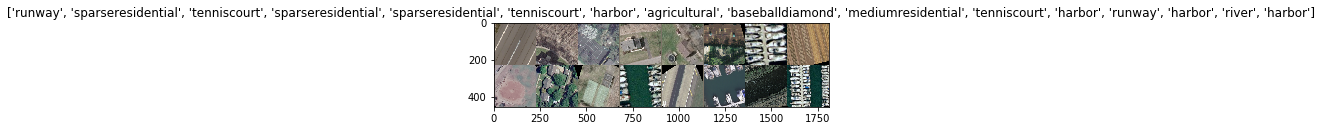

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_idx_to_name[cat] for cat in classes.tolist()])

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. We will use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

Things we'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training we make sure only the weights of the feed-forward neural network are updated. We make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. We save those hyperparameters to use as default values in the next part of the project.

In [5]:
def model_setup(dropout=0.5, hidden_dim = len(class_indices), lr = 0.0001):

    #model = models.densenet121(pretrained=True)
    model = models.vgg16(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
        ('dropout', nn.Dropout(dropout)),
        #dense121:('inputs', nn.Linear(1024, hidden_dim * 4)),
        ('inputs', nn.Linear(25088, hidden_dim * 4)),
        ('relu1', nn.ReLU()),
        ('hidden_layer1', nn.Linear(hidden_dim * 4, hidden_dim * 3)),
        ('relu2', nn.ReLU()),
        ('hidden_layer2', nn.Linear(hidden_dim * 3, len(class_indices) * 2)),
        ('relu3', nn.ReLU()),
        ('hidden_layer3', nn.Linear(hidden_dim * 2, hidden_dim)),
        ('output', nn.LogSoftmax(dim=1))
        ]))

    model.classifier = classifier

    criterion = nn.NLLLoss()

    optimizer = optim.Adam(model.classifier.parameters(), lr )

    model.to(device)

    print(model)

    return model, optimizer, criterion

model, optimizer, criterion = model_setup()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Train the classifier

In [6]:
epochs = 15
print_every = 5
steps = 0
running_loss = 0

model.to(device)

print('Training started!')

model.train()

for e in range(epochs):
    for ii, (inputs, labels) in enumerate(dataloaders['train']):
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            vloss = 0
            accuracy=0
            
            
            for ii, (inputs2, labels2) in enumerate(dataloaders['valid']):
                optimizer.zero_grad()
                
                inputs2, labels2 = inputs2.to(device) , labels2.to(device)
                model.to(device)
                with torch.no_grad():    
                    outputs = model.forward(inputs2)
                    vloss = criterion(outputs, labels2)
                    ps = torch.exp(outputs).data
                    equality = (labels2.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                    
            vloss = vloss / len(dataloaders['valid'])
            accuracy = accuracy /len(dataloaders['valid'])
            
                    
            
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Validation Loss: {:.4f}".format(vloss),
                   "Accuracy: {:.4f}".format(accuracy))
            
            
            running_loss = 0
            model.train()
print('Training ended!')

Training started!
Epoch: 1/15...  Loss: 3.0386 Validation Loss: 0.2164 Accuracy: 0.0312
Epoch: 1/15...  Loss: 3.0460 Validation Loss: 0.2194 Accuracy: 0.0357
Epoch: 1/15...  Loss: 3.0126 Validation Loss: 0.2211 Accuracy: 0.0982
Epoch: 1/15...  Loss: 3.0117 Validation Loss: 0.2083 Accuracy: 0.1295
Epoch: 1/15...  Loss: 2.9985 Validation Loss: 0.2357 Accuracy: 0.1250
Epoch: 1/15...  Loss: 2.9778 Validation Loss: 0.2055 Accuracy: 0.1696
Epoch: 1/15...  Loss: 2.9343 Validation Loss: 0.2065 Accuracy: 0.1429
Epoch: 1/15...  Loss: 2.9390 Validation Loss: 0.2024 Accuracy: 0.1786
Epoch: 1/15...  Loss: 2.8630 Validation Loss: 0.1866 Accuracy: 0.2232
Epoch: 1/15...  Loss: 2.9517 Validation Loss: 0.2035 Accuracy: 0.2500
Epoch: 1/15...  Loss: 2.8870 Validation Loss: 0.1556 Accuracy: 0.2902
Epoch: 1/15...  Loss: 2.7920 Validation Loss: 0.1897 Accuracy: 0.2991
Epoch: 1/15...  Loss: 2.8513 Validation Loss: 0.2202 Accuracy: 0.2589
Epoch: 1/15...  Loss: 2.8190 Validation Loss: 0.1844 Accuracy: 0.2634
Ep

Epoch: 6/15...  Loss: 0.8058 Validation Loss: 0.0133 Accuracy: 0.8616
Epoch: 6/15...  Loss: 0.8427 Validation Loss: 0.1090 Accuracy: 0.8036
Epoch: 6/15...  Loss: 0.6545 Validation Loss: 0.0608 Accuracy: 0.8393
Epoch: 6/15...  Loss: 0.8028 Validation Loss: 0.0998 Accuracy: 0.8571
Epoch: 6/15...  Loss: 0.6658 Validation Loss: 0.0652 Accuracy: 0.8795
Epoch: 6/15...  Loss: 0.6121 Validation Loss: 0.0284 Accuracy: 0.8795
Epoch: 6/15...  Loss: 0.8992 Validation Loss: 0.0247 Accuracy: 0.8929
Epoch: 6/15...  Loss: 0.7428 Validation Loss: 0.0123 Accuracy: 0.8884
Epoch: 6/15...  Loss: 0.6868 Validation Loss: 0.0442 Accuracy: 0.8795
Epoch: 6/15...  Loss: 0.6825 Validation Loss: 0.0365 Accuracy: 0.8482
Epoch: 7/15...  Loss: 0.6493 Validation Loss: 0.0012 Accuracy: 0.8929
Epoch: 7/15...  Loss: 0.7240 Validation Loss: 0.0121 Accuracy: 0.8929
Epoch: 7/15...  Loss: 0.7324 Validation Loss: 0.0458 Accuracy: 0.8973
Epoch: 7/15...  Loss: 0.6124 Validation Loss: 0.0251 Accuracy: 0.8973
Epoch: 7/15...  Loss

Epoch: 12/15...  Loss: 0.4328 Validation Loss: 0.0463 Accuracy: 0.8839
Epoch: 12/15...  Loss: 0.4286 Validation Loss: 0.0257 Accuracy: 0.9152
Epoch: 12/15...  Loss: 0.5233 Validation Loss: 0.0014 Accuracy: 0.9196
Epoch: 12/15...  Loss: 0.5627 Validation Loss: 0.0087 Accuracy: 0.9107
Epoch: 12/15...  Loss: 0.4220 Validation Loss: 0.0013 Accuracy: 0.9152
Epoch: 12/15...  Loss: 0.5688 Validation Loss: 0.0600 Accuracy: 0.8929
Epoch: 12/15...  Loss: 0.5096 Validation Loss: 0.0169 Accuracy: 0.9196
Epoch: 12/15...  Loss: 0.5006 Validation Loss: 0.0063 Accuracy: 0.9152
Epoch: 12/15...  Loss: 0.5603 Validation Loss: 0.0002 Accuracy: 0.9196
Epoch: 12/15...  Loss: 0.4586 Validation Loss: 0.0202 Accuracy: 0.9152
Epoch: 12/15...  Loss: 0.4659 Validation Loss: 0.0835 Accuracy: 0.8839
Epoch: 12/15...  Loss: 0.4737 Validation Loss: 0.0099 Accuracy: 0.9062
Epoch: 12/15...  Loss: 0.5168 Validation Loss: 0.0048 Accuracy: 0.9107
Epoch: 12/15...  Loss: 0.5693 Validation Loss: 0.0039 Accuracy: 0.9107
Epoch:

## Save the checkpoint

Now that your network is trained, save the model so we can load it later for making predictions. We save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. We will attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

TODO: Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [7]:
# TODO: Save the checkpoint
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu
torch.save({'hidden_dim':len(class_indices),
            'state_dict':model.state_dict(),
            'class_to_idx':model.class_to_idx},
            'checkpoint.pth')

## Loading the checkpoint

We implemented a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [8]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(path):
    checkpoint = torch.load('checkpoint.pth')
    hidden_dim = checkpoint['hidden_dim']
    model,_,_ = model_setup(0.5, hidden_dim)
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    
    
load_model('checkpoint.pth')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Evaluate the classifier over test data

Now that the classifier is trained, it is a good time to evaluate the model over the test dataset. Accuracy is calculated for the entire test dataset.

In [9]:
#Switch to model evaluation mode
model.eval()

test_loss = 0
test_accuracy = 0

y_test = []
y_pred = []

for ii, (inputs3, labels3) in enumerate(dataloaders['test']):
    optimizer.zero_grad()
    
    inputs3, labels3 = inputs3.to(device) , labels3.to(device)
    model.to(device)
    
    with torch.no_grad():    
        outputs = model.forward(inputs3)
        test_loss = criterion(outputs, labels3)
        ps = torch.exp(outputs).data
        
        equality = (labels3.data == ps.max(1)[1])
        test_accuracy += equality.type_as(torch.FloatTensor()).mean()
        
    #(true_labels) = labels3.to("cpu")
        
    y_test.extend(labels3.to("cpu").tolist())
    y_pred.extend(ps.max(1)[1].to("cpu").tolist())
    

test_loss = test_loss / len(dataloaders['test'])
test_accuracy = test_accuracy / len(dataloaders['test'])

print("Test Loss: {:.4f}".format(test_loss),
      "Test Accuracy: {:.4f}".format(test_accuracy))


Test Loss: 0.0346 Test Accuracy: 0.8661


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the land structure image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like:

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [8]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    img_pil = Image.open(image)
   
    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = adjustments(img_pil)
    
    return img_tensor

img = (data_dir + '/train' + '/airplane/' + 'airplane01.tif')

img = process_image(img)
print(img.shape)

torch.Size([3, 224, 224])


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

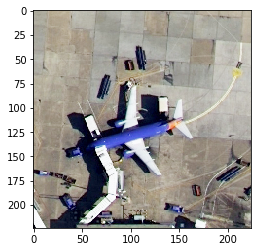

In [9]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

imshow(process_image("../db/UCMerced_LandUse_split/Images/test/airplane/airplane21.tif"))
#\db\UCMerced_LandUse\Images\train

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [10]:
#model.class_to_idx = train_data.class_to_idx
#ctx = model.class_to_idx

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Predict the class from an image file
    model.to(device)
    model.eval()
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch.to(device))
        
    probability = nn.functional.softmax(output.data,dim=1)
    
    model.train()
    
    return probability.topk(topk)

In [13]:
img = (data_dir + '/test' + '/agricultural/' + 'agricultural79.tif')
prob, cl = predict(img, model)
print(prob)
print(cl)

tensor([[9.9937e-01, 3.7966e-04, 1.6091e-04, 4.5288e-05, 1.9959e-05]],
       device='cuda:0')
tensor([[ 0, 17,  8,  7,  3]], device='cuda:0')


In [14]:
img = (data_dir + '/test' + '/airplane/' + 'airplane21.tif')
prob, cl = predict(img, model)
print(prob)
print(cl)

tensor([[9.9952e-01, 2.2945e-04, 1.9220e-04, 4.6142e-05, 7.3002e-06]],
       device='cuda:0')
tensor([[ 1,  6,  4, 19, 15]], device='cuda:0')


In [15]:
img = (data_dir + '/test' + '/beach/' + 'beach90.tif')
prob, cl = predict(img, model)
print(prob)
print(cl)

tensor([[9.9241e-01, 3.3932e-03, 8.5774e-04, 7.9136e-04, 5.6972e-04]],
       device='cuda:0')
tensor([[ 3,  9, 16,  5,  4]], device='cuda:0')


In [16]:
img = (data_dir + '/test' + '/forest/' + 'forest93.tif')
val1, val2 = predict(img, model)
print(val1)
print(val2)

tensor([[0.8850, 0.0531, 0.0205, 0.0151, 0.0126]], device='cuda:0')
tensor([[ 7, 16,  5,  9,  0]], device='cuda:0')


In [17]:
img = (data_dir + '/test' + '/overpass/' + 'overpass68.tif')
val1, val2 = predict(img, model)
print(val1)
print(val2)

tensor([[9.4882e-01, 5.0550e-02, 3.5705e-04, 1.5808e-04, 4.5486e-05]],
       device='cuda:0')
tensor([[14, 17,  8, 19,  1]], device='cuda:0')


In [18]:
img = (data_dir + '/test' + '/river/' + 'ri.tif')
val1, val2 = predict(img, model)
print(val1)
print(val2)

FileNotFoundError: [Errno 2] No such file or directory: '../db/UCMerced_LandUse_split/Images/test/river/ri.tif'

In [12]:
img = (data_dir + '/test' + '/harbor/' + 'harbor79.tif')
val1, val2 = predict(img, model)
print(val1)
print(val2)

tensor([[9.9998e-01, 1.0097e-05, 7.1031e-06, 2.1043e-07, 1.7196e-07]],
       device='cuda:0')
tensor([[10,  0, 15, 19, 11]], device='cuda:0')


## Sanity Checking

Now that we can use a trained model for predictions, let's check to make sure it makes sense. Even if the validation and test accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image.

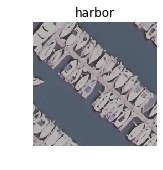

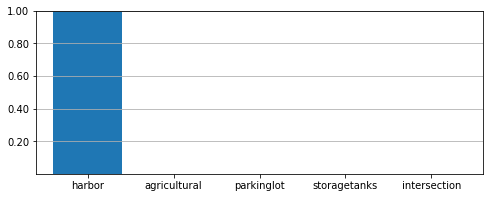

In [11]:
# TODO: Display an image along with the top 5 classes
def check_sanity():
    plt.rcParams["figure.figsize"] = (10,5)
    plt.subplot(211)

    index = 10
    path = data_dir + '/test/harbor/harbor79.tif'

    probabilities, classes = predict(path, model)
    image = process_image(path)
    
    axs = imshow(image, ax = plt)
    axs.axis('off')
    axs.title(class_idx_to_name[index])
    axs.show()
    
    a = np.array(probabilities.cpu()[0].tolist())
    b = [class_idx_to_name[index] for index in classes.cpu()[0].tolist()]
    
    N=float(len(b))
    fig,ax = plt.subplots(figsize=(8,3))
    width = 0.8
    tickLocations = np.arange(N)
    ax.bar(tickLocations, a, width, linewidth=4.0, align = 'center')
    ax.set_xticks(ticks = tickLocations)
    ax.set_xticklabels(b)
    ax.set_xlim(min(tickLocations)-0.6,max(tickLocations)+0.6)
    ax.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
    ax.set_ylim((0,1))
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.show()

check_sanity()

## Calculate Confusion matrix
For all categories, display the normalized confusion matrix.

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Normalized confusion matrix


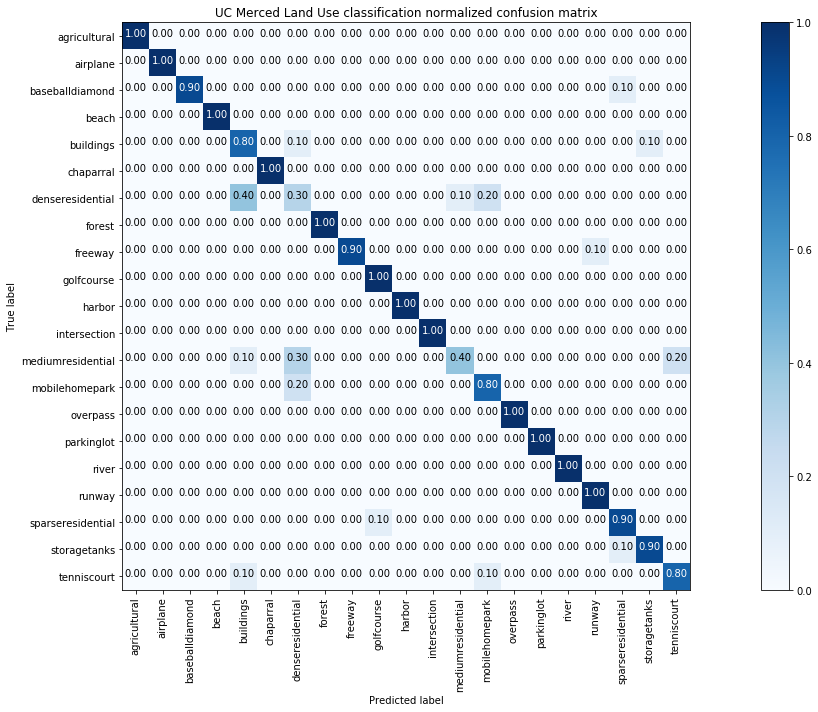

In [21]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plt.rcParams["figure.figsize"] = (20,10)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='UC Merced Land Use classification normalized confusion matrix')

plt.show()
